In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import numpy as np 
import matplotlib.pyplot as plt 

In [6]:
(x_train, y_train),(x_test, y_test) = datasets.mnist.load_data() 

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


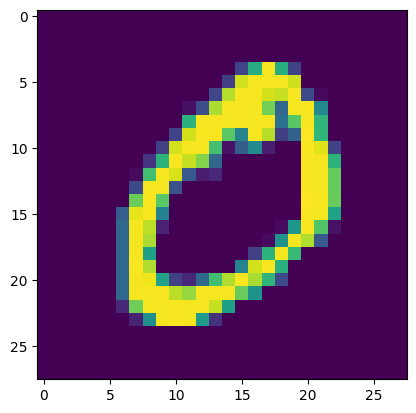

In [10]:
plt.imshow(x_train[1])